In [1]:
# Useful package

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.stats as stat
import networkx as nx
import collections

## Importing the data 
In this study a replication of some of the proposals in the article 'Testing Propositions Derived from Twitter Studies' will be attempted with a different dataset. Indeed, the social media used as a database for this article was Twitter, the goal of the study here is to try to reproduce it but with the Instagram social media. The issue was that Facebook (Owners of Instagram) do not let any automated crawlers exctract data from their database, an authorisation is needed in order to do so. Furthermore, as the team had no prior expertise in crawling, the decision was taken to use available datasets. The issue with this method is that there was not any datasets who had all the information needed for all the studies. Thus 4 different datasets were used. The sources are given in our README.md file.

In [2]:
#Importing the datasets needed for this project
data_users2 = pd.read_csv('datasets/secondary_data/fake_train.txt', sep=',')
data_users3 = pd.read_csv('datasets/secondary_data/fake_test.txt', sep=',')
data_time1 = pd.read_csv('datasets/time_data/data_train.txt', sep=',')
data_time2 = pd.read_csv('datasets/time_data/data_test.txt', sep=',')
data_network = pd.read_excel('datasets/Instagram_Data.xlsx')

C:\Users\laand\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# 1. Circadian rythm
The first study is to reproduce the circadian rythm in the upload of the posts. To do so, a dataset that was used for training a network for event detection techniques will be used. This dataset was separated in two parts, one for training and one for testing many different parameters that we decided to merge for this study. First of all, the **created time** of the post is in absolute time with respect to the scraper or the creator of the dataset and it is the main parameter of the study. Secondly, the **latitude** and **longitude** are a range containing the exact position of the individuals. It will thus help us determine the time zone of the user.

In [3]:
# Concatenate the training and testing datasets
data_r = pd.concat([data_time1, data_time2])
display(data_r.head())
display(data_r.info())

,instagram_id,created_time,region.code,region.max_lat,region.max_lng,region.min_lat,region.min_lng,event_id,hasEvent
0,1199590922631001235_32948340,1457222403,282,40.76986,-73.99448,40.76808,-73.99692,NaN,NaN
1,1199590934955377570_2059344815,1457222404,212,40.76452,-73.98228,40.76274,-73.98472,NaN,NaN
2,1199590928277884518_15214658,1457222404,261,40.76808,-73.98472,40.76630,-73.98716,NaN,NaN
3,1199590930338110928_240726366,1457222404,282,40.76986,-73.99448,40.76808,-73.99692,NaN,NaN
4,1199590955010335936_313377664,1457222407,139,40.75918,-73.97740,40.75740,-73.97984,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 217996 entries, 0 to 184369
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   instagram_id    217996 non-null  object 
 1   created_time    217996 non-null  int64  
 2   region.code     217996 non-null  int64  
 3   region.max_lat  217996 non-null  float64
 4   region.max_lng  217995 non-null  float64
 5   region.min_lat  217995 non-null  float64
 6   region.min_lng  217995 non-null  float64
 7   event_id        77784 non-null   float64
 8   hasEvent        77784 non-null   object 
dtypes: float64(5), int64(2), object(2)
memory usage: 16.6+ MB


None

After correctly loading the data, the absolute time needs to be computed. To do so, the time values are shifted by the initial time and then we extract the hour at which the post was uploaded, and the time should be obtained in seconds. Thus the modulus of (60 sec * 60 min * 24h) is taken to have the seconds of the day at which it has been posted.   

In [4]:
# Remove useless columns
data_r = data_r.drop(['event_id', 'hasEvent', 'region.code', 'instagram_id'], axis=1)

# The modulus of the time obtained is taken that is (nb of seconds in an hour 3600 x 24 hours a day)
data_r['time'] = (data_r['created_time'] - data_r['created_time'].iloc[0])%86400    
display(data_r.head())

,created_time,region.max_lat,region.max_lng,region.min_lat,region.min_lng,time
0,1457222403,40.76986,-73.99448,40.76808,-73.99692,0
1,1457222404,40.76452,-73.98228,40.76274,-73.98472,1
2,1457222404,40.76808,-73.98472,40.76630,-73.98716,1
3,1457222404,40.76986,-73.99448,40.76808,-73.99692,1
4,1457222407,40.75918,-73.97740,40.75740,-73.97984,4


In [5]:
display(data_r.describe())

,created_time,region.max_lat,region.max_lng,region.min_lat,region.min_lng,time
count,2.179960e+05,217996.000000,217995.000000,217995.000000,217995.000000,217996.000000
mean,1.458519e+09,40.764980,-73.977692,40.763200,-73.980132,48095.900416
std,5.589341e+05,0.009582,0.009936,0.009582,0.009936,28870.611597
min,1.457222e+09,40.750280,-73.999360,40.748500,-74.001800,0.000000
25%,1.458502e+09,40.757400,-73.984720,40.755620,-73.987160,14944.000000
50%,1.458690e+09,40.762740,-73.977400,40.760960,-73.979840,57203.000000
75%,1.458873e+09,40.773420,-73.970080,40.771640,-73.972520,73121.000000
max,1.459037e+09,40.793000,-73.953000,40.791220,-73.955440,86399.000000


To count the number of occurences in an hour, we set up a counter of the time divided by the number of seconds in an hour. Thanks to this method, it is possible to plot the number of uploads of posts per hour of the day.

In [6]:
counter_time = collections.Counter(data_r['time'])        #Setting a counter up to know at which second of the day how many posts were uploaded
hour = [x /3600 for x in list(counter_time.keys())]       #getting the time in hours
count = list(counter_time.values())
count_hour = np.zeros(24)
abs_hour = range(24) 

for i in range(len(count)):
    count_hour[math.floor(hour[i])] += count[i] #summing all the posts done in the same hour storing them in a list 

The resulting plot can be seen here below, the issue with this study is that due to the poor scraping of the data, the day of the week at which the post was uploaded can not be isolated. Also, it is only managable to have the relative time of the posts between each other and not the hour of the day. It is possible to see that the trend is correctly reproduced as there is a drop in the number of posts at what can be thought of the usual time of sleep.

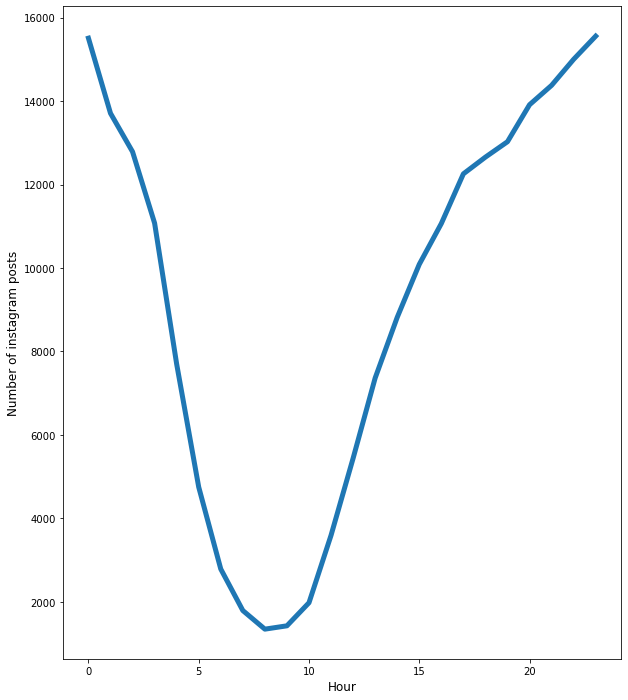

In [7]:
fig = plt.figure(figsize=(10, 12))
plt.plot(abs_hour, count_hour, linewidth=5)  #Plotting the number of posts in function of the hour of the day
plt.xlabel('Relative Hour', fontsize='large')
plt.ylabel('Number of instagram posts', fontsize='large')
plt.show()

# 2. Attention vs. Productivity

For this question, we took a dataset initially used to train a model for fake account recognition on Instagram. Similarly as in the first question, we used the training as well as the test set. We will focus on the number of **posts**, **followers** and **followees** and analyse whether users getting more attention result in more posting, i.e. in more productivity.

In [8]:
# Concatenate the training and testing datasets            
data_users = pd.concat([data_users2, data_users3])
display(data_users.head())
display(data_users.info())

,profile pic,nums/length username,fullname words,nums/length fullname,name==username,description length,external URL,private,#posts,#followers,#follows,fake
0,1,0.27,0,0.0,0,53,0,0,32,1000,955,0
1,1,0.00,2,0.0,0,44,0,0,286,2740,533,0
2,1,0.10,2,0.0,0,0,0,1,13,159,98,0
3,1,0.00,1,0.0,0,82,0,0,679,414,651,0
4,1,0.00,2,0.0,0,0,0,1,6,151,126,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 696 entries, 0 to 119
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   profile pic           696 non-null    int64  
 1   nums/length username  696 non-null    float64
 2   fullname words        696 non-null    int64  
 3   nums/length fullname  696 non-null    float64
 4   name==username        696 non-null    int64  
 5   description length    696 non-null    int64  
 6   external URL          696 non-null    int64  
 7   private               696 non-null    int64  
 8   #posts                696 non-null    int64  
 9   #followers            696 non-null    int64  
 10  #follows              696 non-null    int64  
 11  fake                  696 non-null    int64  
dtypes: float64(2), int64(10)
memory usage: 70.7 KB


None

In [9]:
# Drop useless columns for this questions
data_users = data_users.drop(['profile pic', 'nums/length username', 'fullname words', 'nums/length fullname', 'name==username',
                'description length', 'external URL'], axis=1)
display(data_users.head())

,private,#posts,#followers,#follows,fake
0,0,32,1000,955,0
1,0,286,2740,533,0
2,1,13,159,98,0
3,0,679,414,651,0
4,1,6,151,126,0


The accounts on this dataset are labeled for fake: it is equal to 1 if the account is not fake and equal to 0 if it is. As we would like to get real accounts only, we will remove the fake accounts below before proceeding further.

In [10]:
# Remove fake accounts
data_users = data_users[data_users['fake']==0]
display(data_users.info())
display(data_users.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348 entries, 0 to 59
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   private     348 non-null    int64
 1   #posts      348 non-null    int64
 2   #followers  348 non-null    int64
 3   #follows    348 non-null    int64
 4   fake        348 non-null    int64
dtypes: int64(5)
memory usage: 16.3 KB


None

,private,#posts,#followers,#follows,fake
count,348.000000,348.000000,3.480000e+02,348.000000,348.0
mean,0.433908,197.919540,1.581572e+05,712.873563,0.0
std,0.496326,517.252461,1.187622e+06,1074.541299,0.0
min,0.000000,0.000000,9.000000e+00,0.000000,0.0
25%,0.000000,15.000000,2.402500e+02,231.000000,0.0
50%,0.000000,65.000000,5.770000e+02,438.000000,0.0
75%,1.000000,210.000000,1.483000e+03,695.750000,0.0
max,1.000000,7389.000000,1.533854e+07,7500.000000,0.0


First, we can notice that ll count values are positive integers so we do not have any incoherent negative values. Second we count 348 accounts in our dataset whereas there was 34'004 Twitter users in the paper. That is why we will draw our conclusions very carefully.

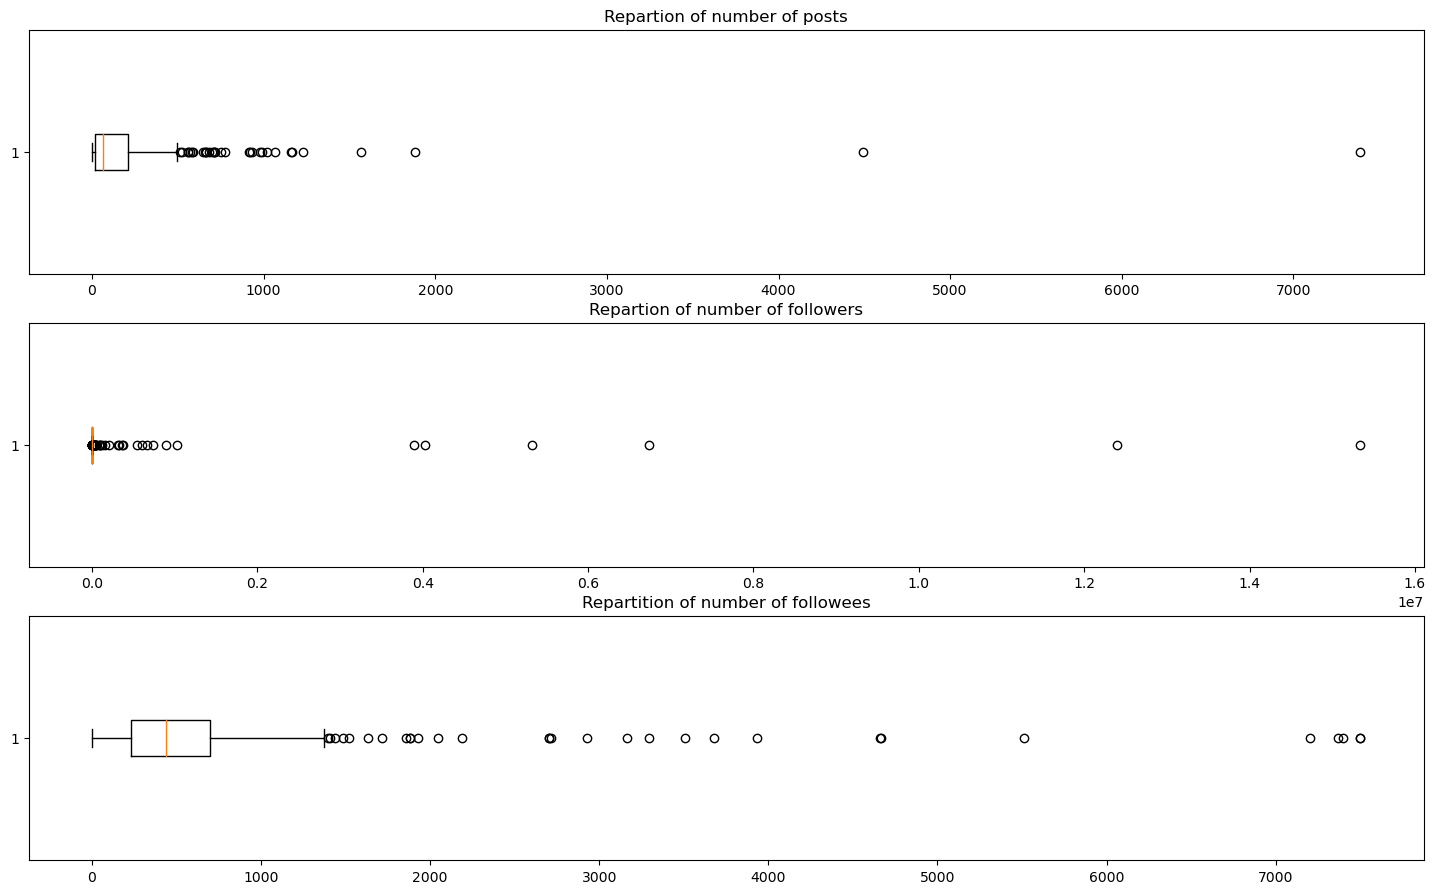

In [11]:
## Data vizualisation tools
# Boxplots

fig = plt.figure(figsize=(18,11), dpi=100)

plt.subplot(311)
plt.title("Repartion of number of posts")
plt.boxplot(data_users['#posts'], vert=False)

plt.subplot(312)
plt.title("Repartion of number of followers")
plt.boxplot(data_users['#followers'], vert=False)

plt.subplot(313)
plt.title("Repartition of number of followees")
plt.boxplot(data_users['#follows'], vert=False)

plt.show()

We can notice that there are many extreme points in the data set. In order to have a closer view of the repartition of the majority of the data, we will plot histograms with values inferior to the third quantile only.

In [30]:
# Computation of third quantiles
users_q3 = data_users['#posts'].quantile(.75)
followers_q3 = data_users['#followers'].quantile(.75)
followees_q3 = data_users['#follows'].quantile(.75)

print("The third quantile of posts count is", users_q3)
print("The third quantile of followers count is", followers_q3)
print("The third quantile of followees count is", followees_q3)

The third quantile of posts count is 210.0
The third quantile of followers count is 1483.0
The third quantile of followees count is 695.75


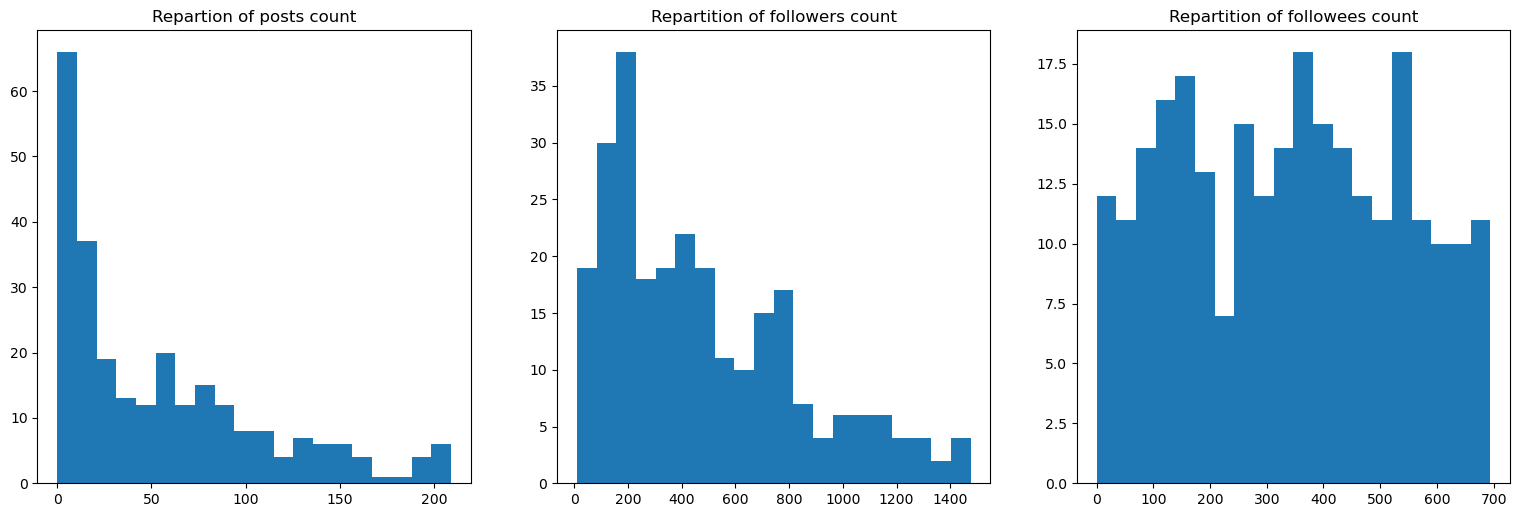

In [13]:
# Histograms

fig = plt.figure(figsize=(19,6), dpi=100)

plt.subplot(131)
plt.title("Repartion of posts count")
plt.hist(data_users[data_users['#posts']<=users_q3]['#posts'], bins=20)

plt.subplot(132)
plt.title("Repartition of followers count")
plt.hist(data_users[data_users['#followers']<=followers_q3]['#followers'], bins=20)

plt.subplot(133)
plt.title("Repartition of followees count")
plt.hist(data_users[data_users['#follows'] <=followees_q3]['#follows'], bins=20)

plt.show()

The dataset contains a few outliers for the number of posts, followers and follwees as we may see on the boxplots. However they are very spread so they have a huge influence on the standard deviation values. For example, the standard deviation for the number of followers is very high (1.187622e+06) compared to the median (577).

If we plot the histograms for the data up the the third quantile, we notice that the number of posts and followers are left-tailed whereas the number of followees is much likely uniformly distributed.

We will then try to reproduce the Figure 3 (A) and (B) of the paper in order to compare the relation between the average number of posts and the number of followers and followees on Twitter with the ones on Instagram.

In [14]:
# Reproduction of Fig. 3 of the paper

# Sum up number of posts per number of followers and number of followees
posts = data_users.groupby('#followers').sum()
posts2 = data_users.groupby('#follows').sum()

# Count number of users with x followers and x followees
followers = data_users[['#followers', '#posts']].groupby('#followers').count()
follows = data_users[['#follows', '#posts']].groupby('#follows').count()

followers['#followers']=followers.index
follows['#follows'] = follows.index

# Compute the average
followers['#posts'] = posts['#posts']/followers['#posts']
follows['#posts'] = posts2['#posts']/follows['#posts']

followers.reset_index(drop=True,inplace=True)
follows.reset_index(drop=True, inplace=True)

display(followers)
display(follows)

,#posts,#followers
0,2.0,9
1,0.0,13
2,6.0,19
3,3.0,33
4,3.0,35
...,...,...
309,1879.0,4021842
310,497.0,5315651
311,334.0,6741307
312,4494.0,12397719


,#posts,#follows
0,751.0,0
1,663.0,3
2,3.0,6
3,4494.0,8
4,7389.0,11
...,...,...
298,1879.0,5514
299,921.0,7202
300,273.0,7369
301,7.0,7399


In [15]:
# Get trend curves by fitting a linear line

p_followers = np.polyfit(followers['#followers'], followers['#posts'], 1)
print(p_followers)

p_follows = np.polyfit(follows['#follows'], follows['#posts'], 1)
print(p_follows)

[1.43524579e-04 1.86930157e+02]
[5.20340797e-02 1.68455765e+02]


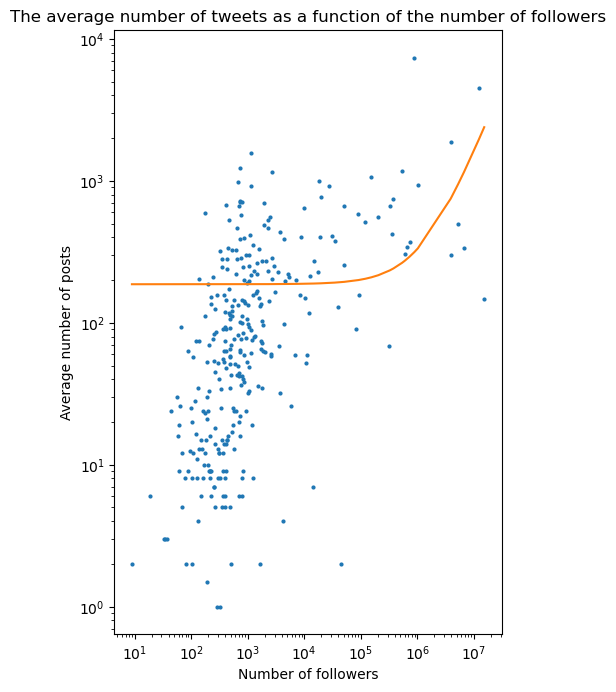

In [16]:
# Plot of the average
fig = plt.figure(figsize=(5,8), dpi=100)

ax = plt.axes()
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("The average number of posts as a function of the number of followers")
plt.plot(followers['#followers'], followers['#posts'], 'o', markersize=2)
plt.plot(followers['#followers'], np.polyval(p_followers, followers['#followers']))

plt.xlabel("Number of followers")
plt.ylabel("Average number of posts")

plt.show()

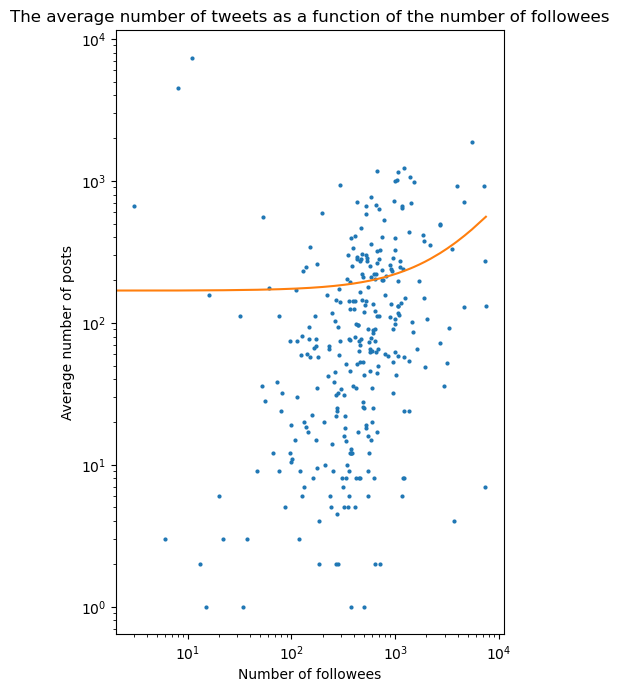

In [17]:
fig = plt.figure(figsize=(5,8), dpi=100)

ax = plt.axes()
ax.set_yscale('log')
ax.set_xscale('log')
plt.title("The average number of posts as a function of the number of followees")
plt.plot(follows['#follows'], follows['#posts'], 'o', markersize=2)
plt.plot(follows['#follows'], np.polyval(p_follows, follows['#follows']))

plt.xlabel("Number of followees")
plt.ylabel("Average number of posts")

plt.show()

In [18]:
# Compute Pearson correlation values

r_followers, p_followers = stat.pearsonr(followers['#followers'], followers['#posts'])
print("The Pearson correlation between number of followers and the average number of posts is ", r_followers)

r_follows, p_follows = stat.pearsonr(follows['#follows'], follows['#posts'])
print("The Pearson correlation between number of followees and the average number of posts is ", r_follows)

The Pearson correlation between number of followers and the average number of posts is  0.33196375208637885
The Pearson correlation between number of followees and the average number of posts is  0.10251721466458893


# 3.  Followers - Followees network

For this question, we used two different datasets:
- The first one is an undirected network of Instagram users with reciprocal links. They are not based on the follower/followee relationships but on positive comments and likes on each other's profile.
- The second one is a directed network of GooglePlus users. The edges are given such that in the edge [A, B] , A follows B on GooglePlus.

In [19]:
display(data_network.head())

print("There are ", np.count_nonzero(data_network), "edges.")
print("There are ", len(data_network), "nodes.")

print(data_network.columns)

,Unnamed: 0,Meredith Stransky,Brittney Mazzella,Yi Cook,Porter Devries,Suzanne Syverson,Ladawn Creason,Mikel Lamberson,Lakendra Lasiter,Kate Shiver,...,Tehmina,Happy Bacha,Younus,AVA,Alfred,Danish,Matloob,Sameed Shahzad,Frazer,Mubashir
0,Meredith Stransky,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Brittney Mazzella,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Yi Cook,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Porter Devries,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Suzanne Syverson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There are  10866 edges.
There are  1000 nodes.
Index(['Unnamed: 0', 'Meredith Stransky  ', 'Brittney Mazzella  ', 'Yi Cook  ',
       'Porter Devries  ', 'Suzanne Syverson  ', 'Ladawn Creason  ',
       'Mikel Lamberson  ', 'Lakendra Lasiter  ', 'Kate Shiver  ',
       ...
       'Tehmina', 'Happy Bacha', 'Younus', 'AVA', 'Alfred', 'Danish',
       'Matloob', 'Sameed Shahzad', 'Frazer', 'Mubashir'],
      dtype='object', length=1001)


In [20]:
# Remove the space at the end of each column name
data_network.columns = data_network.columns.str.rstrip()
print(data_network.columns)

Index(['Unnamed: 0', 'Meredith Stransky', 'Brittney Mazzella', 'Yi Cook',
       'Porter Devries', 'Suzanne Syverson', 'Ladawn Creason',
       'Mikel Lamberson', 'Lakendra Lasiter', 'Kate Shiver',
       ...
       'Tehmina', 'Happy Bacha', 'Younus', 'AVA', 'Alfred', 'Danish',
       'Matloob', 'Sameed Shahzad', 'Frazer', 'Mubashir'],
      dtype='object', length=1001)


We first analyse our dataset by visualising the degree distribution, as well as the mean and median values.

,degree,degree_count,degree_cumsum
0,2,3,3
1,3,3,6
2,4,19,25
3,5,44,69
4,6,71,140
5,7,103,243
6,8,118,361
7,9,120,481
8,10,111,592
9,11,117,709


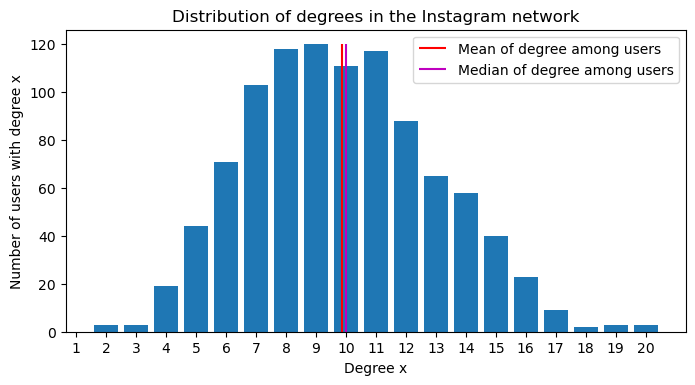

The degree mean is  9.866 .
The degree median is  10 .


In [21]:
# Analyze the distribution of degrees

# Get all degrees (counting in and out edges) for all users
degrees = data_network.sum(axis=1)

# Count how many vertices have a degree of each value
degrees_list = degrees.value_counts()
degrees_list = degrees_list.reset_index()
degrees_list = degrees_list.rename(columns={"index":'degree', 0 : 'degree_count'})
degrees_list = degrees_list.sort_values('degree')
degrees_list = degrees_list.reset_index(drop=True)
degrees_list['degree_cumsum'] = degrees_list['degree_count'].cumsum()
display(degrees_list)

# Plot the distribution of degrees
fig = plt.figure(figsize=(8, 4), dpi=100)

plt.title("Distribution of degrees in the Instagram network")
plt.xticks(range(max(degrees_list['degree'])+1))
plt.bar(degrees_list['degree'], degrees_list['degree_count'])
plt.xlabel('Degree x')
plt.ylabel('Number of users with degree x')

# Compute the mean and median
degree_sum = degrees_list['degree_count'].sum()
degree_med = degrees_list['degree'][degrees_list['degree_cumsum']>= degree_sum/2].iloc[0]
degree_mean = sum(degrees_list['degree_count'] * degrees_list['degree']) / degree_sum

plt.vlines(degree_mean, 0, 120, 'r', label='Mean of degree among users')
plt.vlines(degree_med, 0, 120, 'm', label='Median of degree among users')
plt.legend()
plt.show()

print("The degree mean is ", degree_mean, ".")
print("The degree median is ", degree_med, ".")

,0,1,2,3,4,5,6,7,8,9,...,992,993,994,995,996,997,998,999,degree,LCC
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,0.000000
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,0.022222
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,11,0.000000
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,16,0.000000
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,7,0.000000


    degree  degree_count  degree_cumsum   LCC_sum  LCC_median  LCC_average
0        2             3              3       NaN         NaN          NaN
1        3             3              6       NaN         NaN          NaN
2        4            19             25  0.000000    0.000000     0.000000
3        5            44             69  0.000000    0.000000     0.000000
4        6            71            140  0.500000    0.000000     0.007042
5        7           103            243  0.200000    0.000000     0.001942
6        8           118            361  1.000000    0.000000     0.008475
7        9           120            481  1.047619    0.000000     0.008730
8       10           111            592  1.071429    0.000000     0.009653
9       11           117            709  1.000000    0.000000     0.008547
10      12            88            797  0.977778    0.000000     0.011111
11      13            65            862  0.927273    0.000000     0.014266
12      14            58 

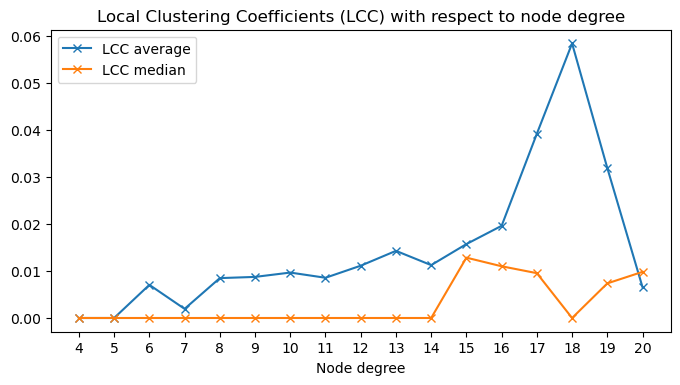

In [22]:
# Compute local clustering coefficient for each degree and plot it
# Plot also the median and average of local clustering coefficient

# Adjacency matrix

adjacency_matrix = data_network.reset_index(drop=True)
n = len(adjacency_matrix)

adjacency_matrix = adjacency_matrix.drop('Unnamed: 0', axis=1)
adjacency_matrix.columns = range(n)
adjacency_matrix['degree'] = adjacency_matrix.sum(axis=0)

adjacency_mat = adjacency_matrix.drop('degree', axis=1).to_numpy()

network = nx.Graph(adjacency_mat)

adjacency_matrix['LCC'] = nx.clustering(network).values() # Outputs a dictionnary!
display(adjacency_matrix.head())

degrees_list['LCC_sum'] = adjacency_matrix[['degree', 'LCC']].groupby('degree').sum()['LCC']
degrees_list['LCC_median'] = adjacency_matrix[['degree', 'LCC']].groupby('degree').median()
degrees_list['LCC_average'] = degrees_list['LCC_sum']/degrees_list['degree_count']
print(degrees_list)

fig = plt.figure(figsize=(8, 4), dpi=100)
plt.title("Local Clustering Coefficients (LCC) with respect to node degree")
plt.xlabel("Node degree")
plt.xticks(range(max(degrees_list['degree'])+1))

plt.plot(degrees_list['degree'], degrees_list['LCC_average'], 'x-', label='LCC average')
plt.plot(degrees_list['degree'], degrees_list['LCC_median'], 'x-', label='LCC median')

plt.legend()
plt.show()

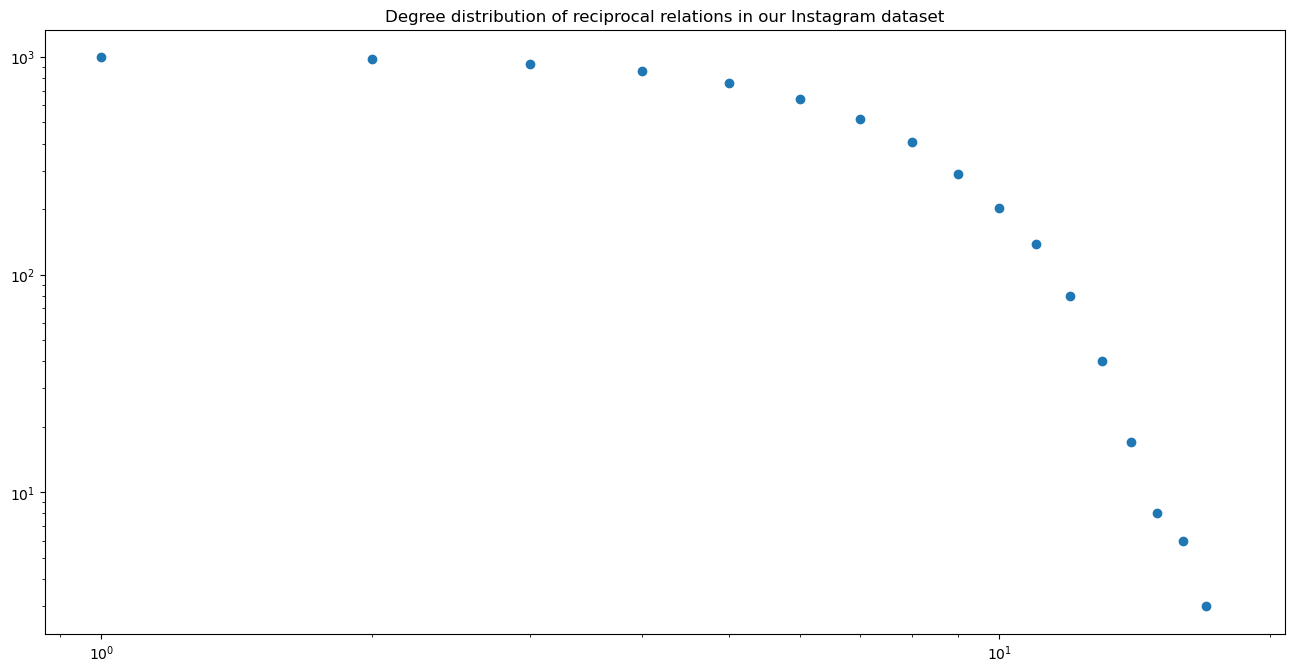

In [23]:
# Reproduction of Fig.4 of the paper
degrees_list['degree_ccs'] = degrees_list['degree_count'].sum() - degrees_list['degree_cumsum']

fig = plt.figure(figsize=(16, 8), dpi=100)
ax = plt.axes()
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Degree distribution of reciprocal relations in our Instagram dataset")
#plt.xticks(range(max(degrees_list['degree'])+1))
plt.plot(degrees_list['degree_ccs'], 'o')

plt.show()

### Comparison these results and the one from the paper to other social networks data such as Google Plus

As our first dataset on Instagram data values was undirected, we will compare the Figure 4 in the paper with the Google Plus follower/followee network.

In [24]:
# Import Google Plus directed network

gplus_network = pd.read_csv('datasets/Gplus/gplus_combined.txt', sep=' ', header=0)

In [25]:
# It is a directed graph, i.e. A follows B
gplus_network = gplus_network.rename(columns = {'116374117927631468606': 'egoID_A', 
                                                '101765416973555767821': 'egoID_B'})

display(gplus_network.head())
print(gplus_network.describe())

,egoID_A,egoID_B
0,112188647432305746617,107727150903234299458
1,116719211656774388392,100432456209427807893
2,117421021456205115327,101096322838605097368
3,116407635616074189669,113556266482860931616
4,105706178492556563330,111169963967137030210


                      egoID_A                egoID_B
count                30494865               30494865
unique                  72271                 107596
top     111091089527727420853  111091089527727420853
freq                    49041                  60957


In [26]:
gplus_out_degrees = gplus_network.groupby('egoID_A').count()
gplus_in_degrees = gplus_network.groupby('egoID_B').count()

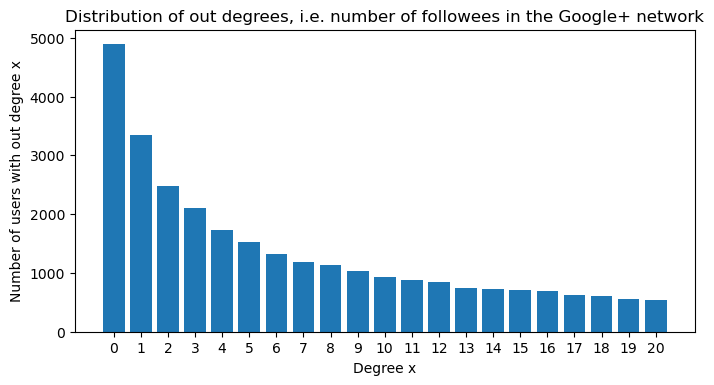

In [33]:
# Plot of the out degree distribution until degree=20

gplus_out_degrees_count = gplus_out_degrees['egoID_B'].value_counts()

fig = plt.figure(figsize=(8, 4), dpi=100)

plt.title("Distribution of out degrees, i.e. number of followees in the Google+ network")
plt.bar(range(21), gplus_out_degrees_count[0:21])
plt.xticks(range(21))
plt.xlabel("Degree x")
plt.ylabel("Number of users with out degree x")

plt.show()

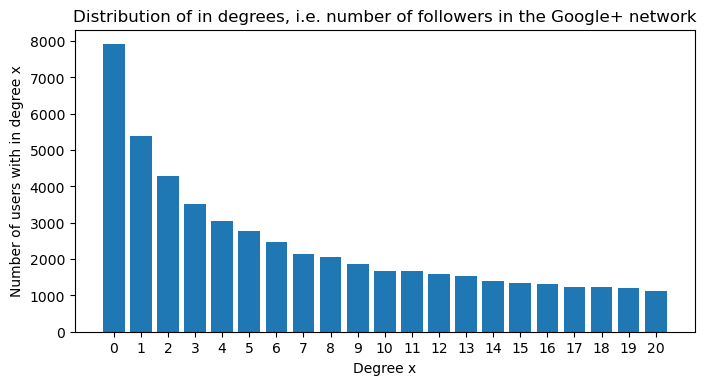

In [28]:
# Plot of the in degree distribution until degree=20

gplus_in_degrees_count = gplus_in_degrees['egoID_A'].value_counts()

fig = plt.figure(figsize=(8, 4), dpi=100)

plt.title("Distribution of in degrees, i.e. number of followers in the Google+ network")
plt.bar(range(21), gplus_in_degrees_count[0:21])
plt.xticks(range(21))
plt.xlabel("Degree x")
plt.ylabel("Number of users with in degree x")

plt.show()

We can notice that the Google Plus in and out degree distribution are left-tailed whereas our Instagram dataset was centered around the mean.

We will then try to reproduce the figure 4 for the in and out degree distribution.

out_degree    False
in_degree     False
dtype: bool


,out_degree,in_degree,out_degree_ccs,in_degree_ccs
1,4893.0,7917.0,67378.0,99679.0
2,3341.0,5397.0,64037.0,94282.0
3,2481.0,4285.0,61556.0,89997.0
4,2110.0,3508.0,59446.0,86489.0
5,1738.0,3046.0,57708.0,83443.0


,out_degree,in_degree,out_degree_ccs,in_degree_ccs
46900,0.0,1.0,1.0,3.0
49041,1.0,0.0,0.0,3.0
50346,0.0,1.0,0.0,2.0
54762,0.0,1.0,0.0,1.0
60957,0.0,1.0,0.0,0.0


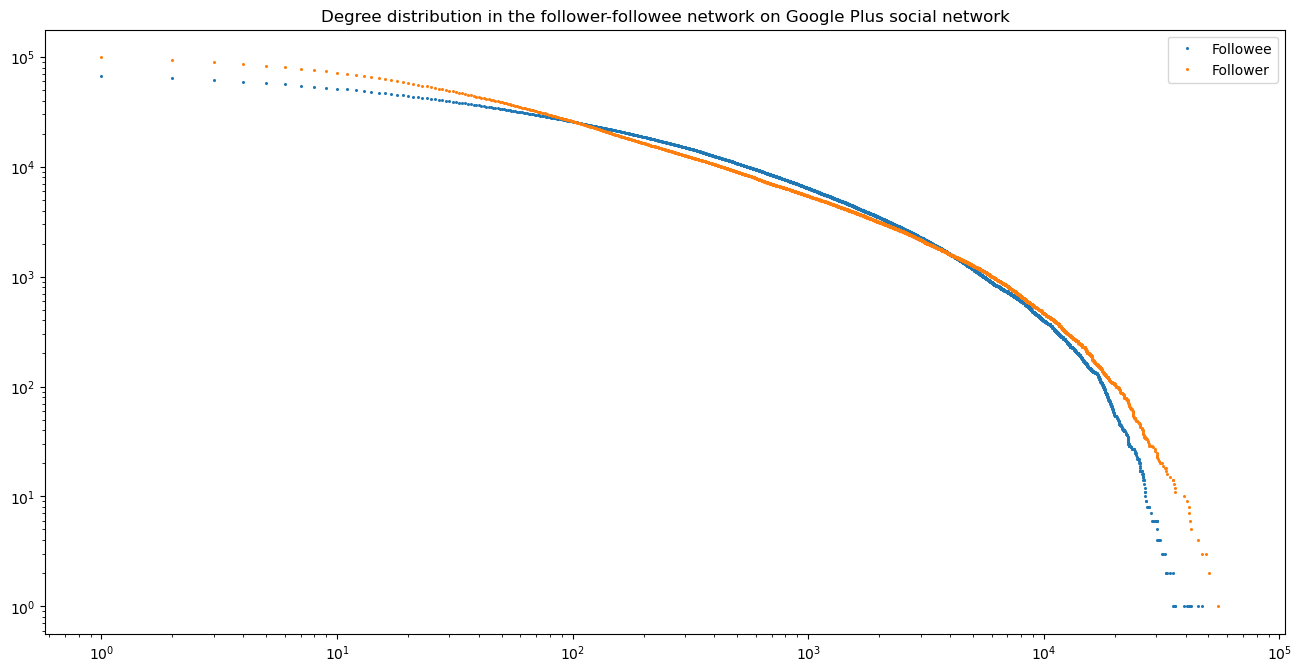

In [29]:
# Plot of the complementary  cumulative distribution of in and out degrees

gplus_degrees = pd.concat([gplus_out_degrees_count, gplus_in_degrees_count], axis=1)
gplus_degrees = gplus_degrees.rename(columns={'egoID_B':'out_degree', 'egoID_A':'in_degree'})
gplus_degrees = gplus_degrees.fillna(0) # Replace NaN values with  values

print(gplus_degrees.any().isna()) # Check for any NaN value

gplus_degrees['out_degree_ccs'] = gplus_degrees['out_degree'].sum() - gplus_degrees['out_degree'].cumsum()
gplus_degrees['in_degree_ccs'] = gplus_degrees['in_degree'].sum() - gplus_degrees['in_degree'].cumsum()

display(gplus_degrees.head())
display(gplus_degrees.tail())

fig = plt.figure(figsize=(16, 8), dpi=100)

ax = plt.axes()
ax.set_yscale('log')
ax.set_xscale('log')

plt.title("Degree distribution in the follower-followee network on Google Plus social network")
plt.plot(gplus_degrees['out_degree_ccs'], 'o', markersize=1.2, label='Followee')
plt.plot(gplus_degrees['in_degree_ccs'], 'o', markersize=1.2, label='Follower')

plt.legend()
plt.show()